# Job Shop Scheduling Benchmarking Environment

This notebook introduces an open-source GitHub repository designed to benchmark and solve a wide range of machine scheduling problems, with a focus on job shop scheduling (JSP) and related problem types. Developed to address the long-standing need for a comprehensive testing environment, this resource supports various problem configurations, including classical Job Shops (JSP), Flow Shops (FSP), Flexible Job Shops (FJSP), Assembly scheduling with dependencies (FAJSP), and Flexible Job Shops with Sequence-Dependent Setup Times (FJSP-SDST).

This repository includes a diverse set of approaches, from traditional heuristics and meta-heuristics to exact solutions and advanced deep reinforcement learning techniques. With this environment, researchers, practitioners, and machine scheduling enthusiasts can experiment with and benchmark their methods, contributing to ongoing advancements in operations research and machine learning for scheduling applications.

Let’s start by importing the required packages:

In [1]:
import random

from plotting.drawer import plot_gantt_chart, draw_precedence_relations
from data_parsers.parser_fjsp import parse_fjsp
from scheduling_environment.jobShop import JobShop

from solution_methods.helper_functions import load_job_shop_env, load_parameters
from solution_methods.dispatching_rules.run_dispatching_rules import run_dispatching_rules
from solution_methods.GA.src.initialization import initialize_run
from solution_methods.GA.run_GA import run_GA
from solution_methods.MILP.run_MILP import run_MILP
from solution_methods.FJSP_DRL.run_FJSP_DRL import run_FJSP_DRL

#### Environment Configuration

We start by configuring the environment. For this, we provide a set of parsers that can be used to parse data files from various benchmarking instances from the literature to configure the JobShop environment. As many different sources of instances exist, the parsers parse the information from the data format into the data objectives from the benchmarking environment. You can find the parsers in the 'data_parsers' folder and can use them as follows:

##### Instance Parsing:

In [2]:
jobShopEnv = JobShop()
jobShopEnv = parse_fjsp(jobShopEnv, '/fjsp/brandimarte/MK01.fjs')

We also provide a 'helper function', that creates the JobShop() object, and selects based on the naming of the problem instance the right parser to be used:

In [3]:
jobShopEnv = load_job_shop_env('/fjsp/brandimarte/MK01.fjs')

##### Instance inspection:

To inspect the instance we can plot it precedence relations:

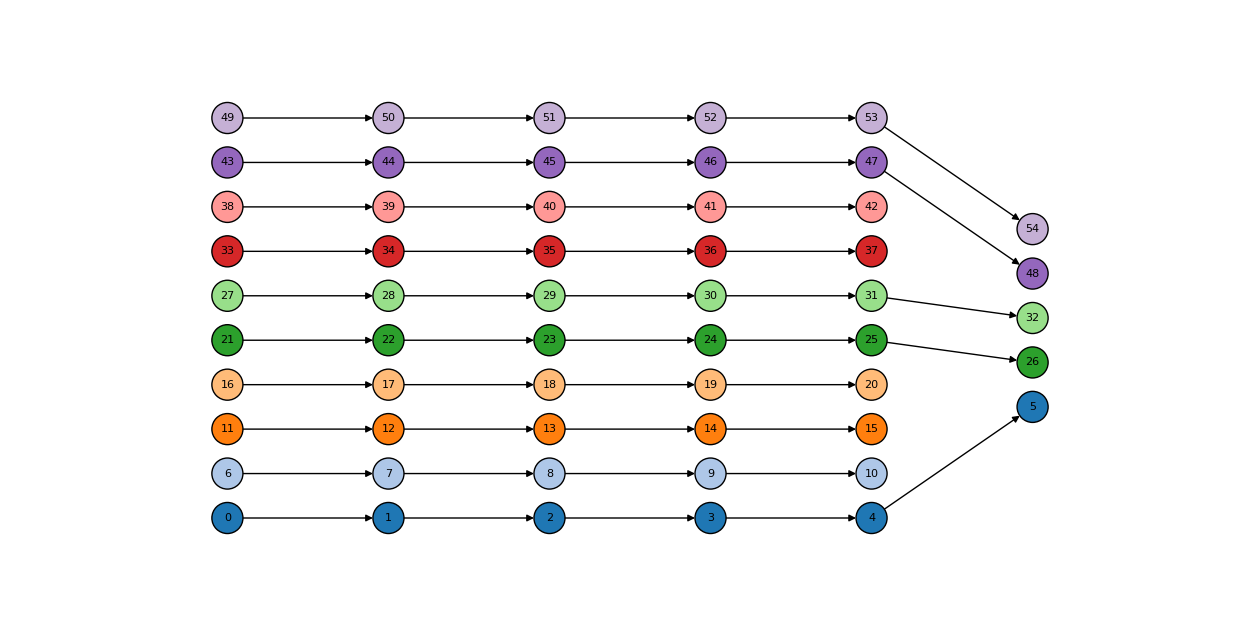

In [4]:
draw_precedence_relations(jobShopEnv)

##### Object ineractions:

We can now interact with the jobShopEnv to inspect its job, operation and machine objects, and make use of scheduling operators to schedule different operations within the environment. 

In [5]:
# Display the Job Shop Environment information
print('Job Shop Environment:')
print(jobShopEnv)

Job Shop Environment:
<JobShop(instance='/fjsp/brandimarte/MK01.fjs', jobs=10, operations=55, machines=6)>


In [6]:
# Display the list of jobs in the environment
print('With the following Jobs:')
print(jobShopEnv.jobs)

With the following Jobs:
[<Job(job_id=0)>, <Job(job_id=1)>, <Job(job_id=2)>, <Job(job_id=3)>, <Job(job_id=4)>, <Job(job_id=5)>, <Job(job_id=6)>, <Job(job_id=7)>, <Job(job_id=8)>, <Job(job_id=9)>]


In [7]:
# Display the operations of the first job (job_id=0)
print('Where the first job (job_id=0) has the following operations:')
job = jobShopEnv.get_job(job_id=0)
print(job.operations)

Where the first job (job_id=0) has the following operations:
[<Operation(job_id=0, operation_id=0)>, <Operation(job_id=0, operation_id=1)>, <Operation(job_id=0, operation_id=2)>, <Operation(job_id=0, operation_id=3)>, <Operation(job_id=0, operation_id=4)>, <Operation(job_id=0, operation_id=5)>]


#### Starting to schedule

We show how to ineract with the scheduling environment by building a simple 'scheduler'. This scheduler select randomly an operation to be scheduled from the set of operations that are available for scheduling

In [8]:
jobShopEnv = load_job_shop_env('/fjsp/brandimarte/MK04.fjs')
jobShopEnv.update_operations_available_for_scheduling()
while len(jobShopEnv.scheduled_operations) < jobShopEnv.nr_of_operations:
    operation = random.choice(jobShopEnv.operations_available_for_scheduling)
    machine_id = random.choice(list(operation.processing_times.keys()))
    duration = operation.processing_times[machine_id]
    jobShopEnv.schedule_operation_on_machine(operation, machine_id, duration)
    jobShopEnv.update_operations_available_for_scheduling()

The solution is generated with the jobShopEnv.schedule_operation_on_machine(operation, machine_id, duration) function. This function schedules an operation on the specified machine by adding it after the last operation that has already been scheduled on that machine.

Other functions to schedule operations are also provided, such as:

- jobShopEnv.schedule_operation_with_backfilling(operation, machine_id, duration)

This function schedules an operation at the earliest possible time with backfilling. It checks if there is an earlier gap in the schedule where the operation can be performed. If a suitable gap is found, the operation is scheduled to make use of unused time, resulting in a more efficient schedule. Backfilling allows the system to maximize machine utilization by filling in idle periods between operations.

- jobShopEnv.schedule_operation_on_machine_at_time(operation, machine_id, start_time, duration)

This function schedules an operation on a specified machine at a given start time. It ensures that the operation is placed at the exact time specified, taking into account any necessary setup times or constraints. This method provides more control over the scheduling process when a specific time is required for the operation to begin.

##### Plotting solution

After a schedule is obtained, we can pass the jobShopEnvironment to a plotting function, to plot the found solution:

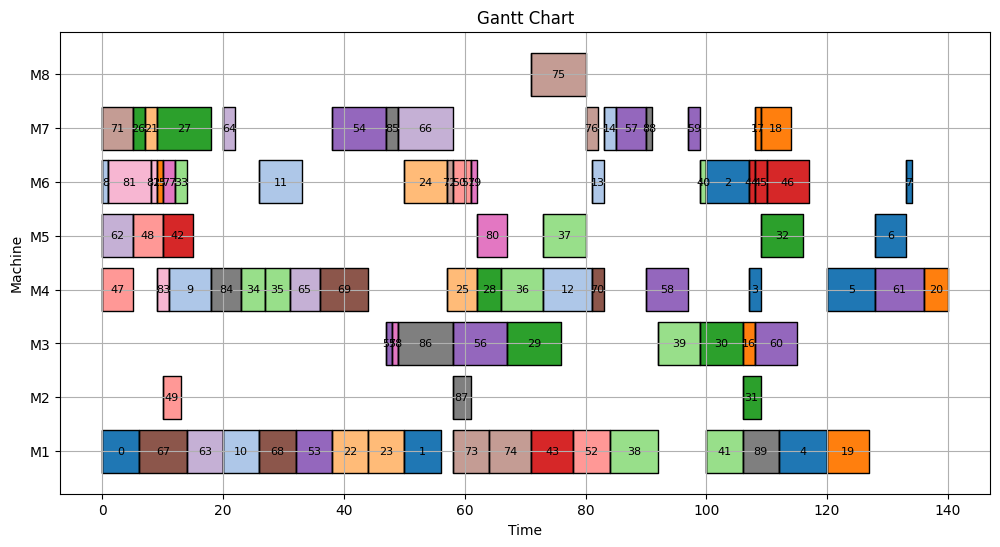

In [9]:
plot_gantt_chart(jobShopEnv);

### Solution Methods

The methods used to address variants of the Job Shop Scheduling Problem (JSP) can be broadly categorized into three main groups: 

- Exact Algorithms
- Heuristic Algorithms
- Machine Learning Approaches

In this project, we have implemented a variety of methods from each of these categories in a standardized way. This allows users to configure their problem environment and pass it to the appropriate solution method. Below, we provide a few examples demonstrating how the solution methods interact with the configured problem environments.

The parameters for different solution methods are specified in configuration files (.toml), which are located in the 'configs' directory. These files define the problem instance to be solved as well as the associated parameters for solving it. In the 'custom_problem_instance' tutorial, we show how these parameters can be included directly in the code, bypassing the need for a parameter .toml file.

#### Dispatching Rules

INFO:root:Makespan: 1823


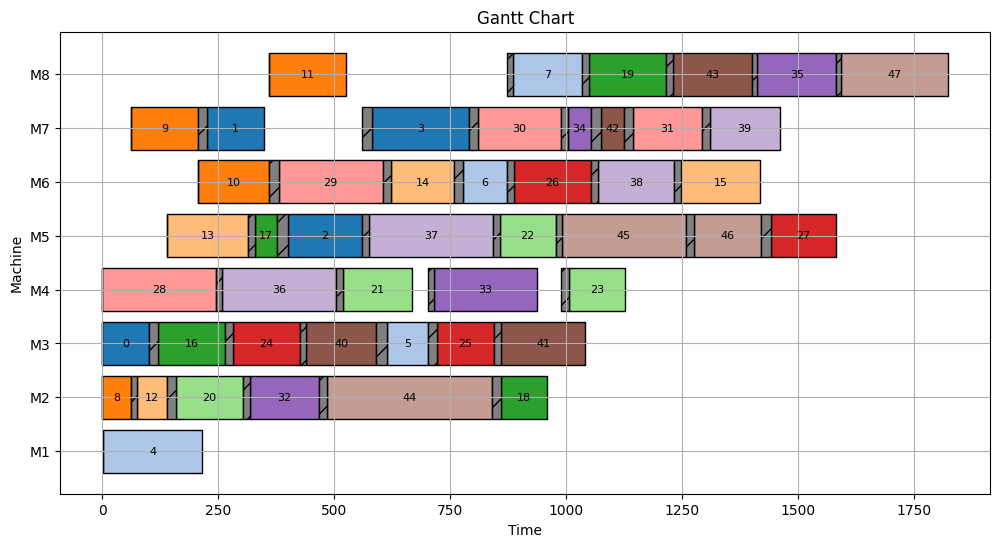

In [10]:
parameters = load_parameters("configs/dispatching_rules.toml")
jobShopEnv = load_job_shop_env(parameters['instance'].get('problem_instance'))

makespan, jobShopEnv = run_dispatching_rules(jobShopEnv, **parameters)
plot_gantt_chart(jobShopEnv);

#### Genetic Algorithm    

INFO:root:gen	avg     	std           	min    	max    
0  	[2140.6]	[190.79947589]	[1838.]	[2574.]
INFO:root:
INFO:root:1  	[1995.8]	[89.29703243] 	[1838.]	[2111.]
INFO:root:2  	[1933.9]	[96.53750566] 	[1838.]	[2111.]
INFO:root:3  	[1895.5]	[84.19055767] 	[1838.]	[2085.]
INFO:root:4  	[1868.3]	[61.0885423]  	[1806.]	[2023.]
INFO:root:5  	[1936.5]	[147.32294458]	[1838.]	[2276.]
INFO:root:6  	[1885.8]	[119.04184138]	[1816.]	[2197.]
INFO:root:7  	[1931.6]	[163.01055181]	[1816.]	[2197.]
INFO:root:8  	[1816.8]	[8.20731381]  	[1802.]	[1838.]
INFO:root:9  	[1830.1]	[52.25409075] 	[1802.]	[1986.]
INFO:root:10 	[1840.4]	[67.60650856] 	[1761.]	[1968.]
INFO:root:Makespan: 1761


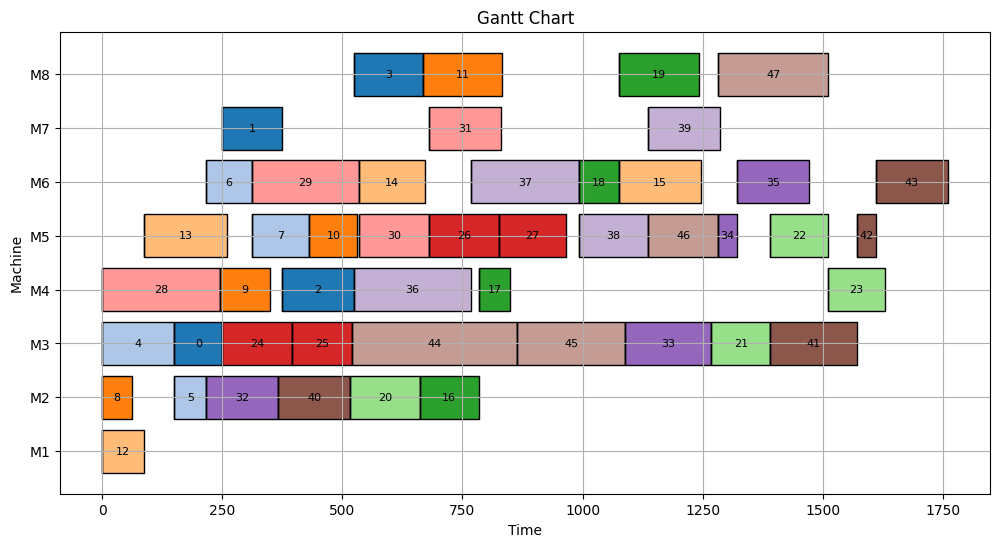

In [11]:
parameters = load_parameters("configs/GA.toml")
jobShopEnv = load_job_shop_env(parameters['instance'].get('problem_instance'))

population, toolbox, stats, hof = initialize_run(jobShopEnv, **parameters)
makespan, jobShopEnv = run_GA(jobShopEnv, population, toolbox, stats, hof, **parameters)

plot_gantt_chart(jobShopEnv);

#### Mixed-Interger Linear Programming

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-07


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-07


Set parameter TimeLimit to value 3600


INFO:gurobipy:Set parameter TimeLimit to value 3600


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1100 rows, 551 columns and 3000 nonzeros


INFO:gurobipy:Optimize a model with 1100 rows, 551 columns and 3000 nonzeros


Model fingerprint: 0xad5240b6


INFO:gurobipy:Model fingerprint: 0xad5240b6


Variable types: 1 continuous, 550 integer (450 binary)


INFO:gurobipy:Variable types: 1 continuous, 550 integer (450 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 8e+03]


INFO:gurobipy:  Matrix range     [1e+00, 8e+03]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [5e+01, 8e+03]


INFO:gurobipy:  RHS range        [5e+01, 8e+03]


Presolve removed 100 rows and 0 columns


INFO:gurobipy:Presolve removed 100 rows and 0 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 1000 rows, 551 columns, 2900 nonzeros


INFO:gurobipy:Presolved: 1000 rows, 551 columns, 2900 nonzeros


Variable types: 0 continuous, 551 integer (450 binary)


INFO:gurobipy:Variable types: 0 continuous, 551 integer (450 binary)


INFO:gurobipy:


Root relaxation: objective 8.590000e+02, 269 iterations, 0.01 seconds (0.00 work units)


INFO:gurobipy:Root relaxation: objective 8.590000e+02, 269 iterations, 0.01 seconds (0.00 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0  859.00000    0   73          -  859.00000      -     -    0s


INFO:gurobipy:     0     0  859.00000    0   73          -  859.00000      -     -    0s


H    0     0                    1550.0000000  859.00000  44.6%     -    0s


INFO:gurobipy:H    0     0                    1550.0000000  859.00000  44.6%     -    0s


H    0     0                    1538.0000000  859.00000  44.1%     -    0s


INFO:gurobipy:H    0     0                    1538.0000000  859.00000  44.1%     -    0s


H    0     0                    1522.0000000  957.51569  37.1%     -    0s


INFO:gurobipy:H    0     0                    1522.0000000  957.51569  37.1%     -    0s


H    0     0                    1521.0000000  957.51569  37.0%     -    0s


INFO:gurobipy:H    0     0                    1521.0000000  957.51569  37.0%     -    0s


     0     0  957.51569    0  176 1521.00000  957.51569  37.0%     -    0s


INFO:gurobipy:     0     0  957.51569    0  176 1521.00000  957.51569  37.0%     -    0s


H    0     0                    1490.0000000  957.51569  35.7%     -    0s


INFO:gurobipy:H    0     0                    1490.0000000  957.51569  35.7%     -    0s


     0     0  963.00000    0   97 1490.00000  963.00000  35.4%     -    0s


INFO:gurobipy:     0     0  963.00000    0   97 1490.00000  963.00000  35.4%     -    0s


     0     0  963.00000    0  101 1490.00000  963.00000  35.4%     -    0s


INFO:gurobipy:     0     0  963.00000    0  101 1490.00000  963.00000  35.4%     -    0s


H    0     0                    1441.0000000  963.00000  33.2%     -    0s


INFO:gurobipy:H    0     0                    1441.0000000  963.00000  33.2%     -    0s


     0     0  972.32133    0  164 1441.00000  972.32133  32.5%     -    0s


INFO:gurobipy:     0     0  972.32133    0  164 1441.00000  972.32133  32.5%     -    0s


     0     0  972.75381    0  157 1441.00000  972.75381  32.5%     -    0s


INFO:gurobipy:     0     0  972.75381    0  157 1441.00000  972.75381  32.5%     -    0s


     0     0  972.75381    0  155 1441.00000  972.75381  32.5%     -    0s


INFO:gurobipy:     0     0  972.75381    0  155 1441.00000  972.75381  32.5%     -    0s


H    0     0                    1440.0000000  987.17883  31.4%     -    0s


INFO:gurobipy:H    0     0                    1440.0000000  987.17883  31.4%     -    0s


H    0     0                    1423.0000000  987.17883  30.6%     -    0s


INFO:gurobipy:H    0     0                    1423.0000000  987.17883  30.6%     -    0s


     0     0  987.17883    0  164 1423.00000  987.17883  30.6%     -    0s


INFO:gurobipy:     0     0  987.17883    0  164 1423.00000  987.17883  30.6%     -    0s


     0     0  987.36665    0  164 1423.00000  987.36665  30.6%     -    0s


INFO:gurobipy:     0     0  987.36665    0  164 1423.00000  987.36665  30.6%     -    0s


     0     0  987.57037    0  162 1423.00000  987.57037  30.6%     -    0s


INFO:gurobipy:     0     0  987.57037    0  162 1423.00000  987.57037  30.6%     -    0s


     0     0  987.57037    0  165 1423.00000  987.57037  30.6%     -    0s


INFO:gurobipy:     0     0  987.57037    0  165 1423.00000  987.57037  30.6%     -    0s


H    0     0                    1422.0000000  987.57037  30.6%     -    0s


INFO:gurobipy:H    0     0                    1422.0000000  987.57037  30.6%     -    0s


H    0     0                    1417.0000000  987.57037  30.3%     -    0s


INFO:gurobipy:H    0     0                    1417.0000000  987.57037  30.3%     -    0s


H    0     0                    1416.0000000  991.87494  30.0%     -    0s


INFO:gurobipy:H    0     0                    1416.0000000  991.87494  30.0%     -    0s


H    0     0                    1415.0000000  991.87494  29.9%     -    0s


INFO:gurobipy:H    0     0                    1415.0000000  991.87494  29.9%     -    0s


     0     0  991.87494    0  162 1415.00000  991.87494  29.9%     -    0s


INFO:gurobipy:     0     0  991.87494    0  162 1415.00000  991.87494  29.9%     -    0s


     0     0  992.28689    0  167 1415.00000  992.28689  29.9%     -    0s


INFO:gurobipy:     0     0  992.28689    0  167 1415.00000  992.28689  29.9%     -    0s


     0     0  992.32802    0  168 1415.00000  992.32802  29.9%     -    0s


INFO:gurobipy:     0     0  992.32802    0  168 1415.00000  992.32802  29.9%     -    0s


H    0     0                    1413.0000000  992.32802  29.8%     -    0s


INFO:gurobipy:H    0     0                    1413.0000000  992.32802  29.8%     -    0s


H    0     0                    1398.0000000  992.32802  29.0%     -    0s


INFO:gurobipy:H    0     0                    1398.0000000  992.32802  29.0%     -    0s


     0     0  992.39527    0  172 1398.00000  992.39527  29.0%     -    0s


INFO:gurobipy:     0     0  992.39527    0  172 1398.00000  992.39527  29.0%     -    0s


H    0     0                    1391.0000000  993.57533  28.6%     -    0s


INFO:gurobipy:H    0     0                    1391.0000000  993.57533  28.6%     -    0s


     0     0  993.57533    0  167 1391.00000  993.57533  28.6%     -    0s


INFO:gurobipy:     0     0  993.57533    0  167 1391.00000  993.57533  28.6%     -    0s


     0     0  993.57533    0  167 1391.00000  993.57533  28.6%     -    0s


INFO:gurobipy:     0     0  993.57533    0  167 1391.00000  993.57533  28.6%     -    0s


H    0     0                    1390.0000000  993.57533  28.5%     -    0s


INFO:gurobipy:H    0     0                    1390.0000000  993.57533  28.5%     -    0s


     0     0  993.57533    0  171 1390.00000  993.57533  28.5%     -    0s


INFO:gurobipy:     0     0  993.57533    0  171 1390.00000  993.57533  28.5%     -    0s


     0     0  993.63743    0  168 1390.00000  993.63743  28.5%     -    0s


INFO:gurobipy:     0     0  993.63743    0  168 1390.00000  993.63743  28.5%     -    0s


H    0     0                    1389.0000000  993.64122  28.5%     -    0s


INFO:gurobipy:H    0     0                    1389.0000000  993.64122  28.5%     -    0s


     0     0  994.46460    0  163 1389.00000  994.46460  28.4%     -    0s


INFO:gurobipy:     0     0  994.46460    0  163 1389.00000  994.46460  28.4%     -    0s


     0     0  994.99412    0  164 1389.00000  994.99412  28.4%     -    0s


INFO:gurobipy:     0     0  994.99412    0  164 1389.00000  994.99412  28.4%     -    0s


     0     0  995.16299    0  164 1389.00000  995.16299  28.4%     -    0s


INFO:gurobipy:     0     0  995.16299    0  164 1389.00000  995.16299  28.4%     -    0s


     0     0  995.20157    0  170 1389.00000  995.20157  28.4%     -    0s


INFO:gurobipy:     0     0  995.20157    0  170 1389.00000  995.20157  28.4%     -    0s


H    0     0                    1378.0000000  996.12097  27.7%     -    0s


INFO:gurobipy:H    0     0                    1378.0000000  996.12097  27.7%     -    0s


     0     0  996.12097    0  168 1378.00000  996.12097  27.7%     -    0s


INFO:gurobipy:     0     0  996.12097    0  168 1378.00000  996.12097  27.7%     -    0s


H    0     0                    1377.0000000  996.35259  27.6%     -    0s


INFO:gurobipy:H    0     0                    1377.0000000  996.35259  27.6%     -    0s


     0     0  996.52745    0  169 1377.00000  996.52745  27.6%     -    0s


INFO:gurobipy:     0     0  996.52745    0  169 1377.00000  996.52745  27.6%     -    0s


     0     0  996.52946    0  167 1377.00000  996.52946  27.6%     -    0s


INFO:gurobipy:     0     0  996.52946    0  167 1377.00000  996.52946  27.6%     -    0s


     0     0  996.80329    0  173 1377.00000  996.80329  27.6%     -    0s


INFO:gurobipy:     0     0  996.80329    0  173 1377.00000  996.80329  27.6%     -    0s


H    0     0                    1362.0000000  997.00000  26.8%     -    0s


INFO:gurobipy:H    0     0                    1362.0000000  997.00000  26.8%     -    0s


H    0     0                    1344.0000000  997.00000  25.8%     -    0s


INFO:gurobipy:H    0     0                    1344.0000000  997.00000  25.8%     -    0s


     0     0  997.00000    0  149 1344.00000  997.00000  25.8%     -    0s


INFO:gurobipy:     0     0  997.00000    0  149 1344.00000  997.00000  25.8%     -    0s


H    0     0                    1329.0000000  997.00000  25.0%     -    0s


INFO:gurobipy:H    0     0                    1329.0000000  997.00000  25.0%     -    0s


     0     0  997.00000    0  167 1329.00000  997.00000  25.0%     -    0s


INFO:gurobipy:     0     0  997.00000    0  167 1329.00000  997.00000  25.0%     -    0s


     0     0  997.00000    0  144 1329.00000  997.00000  25.0%     -    0s


INFO:gurobipy:     0     0  997.00000    0  144 1329.00000  997.00000  25.0%     -    0s


H    0     0                    1321.0000000  997.00000  24.5%     -    0s


INFO:gurobipy:H    0     0                    1321.0000000  997.00000  24.5%     -    0s


     0     0  997.00000    0  156 1321.00000  997.00000  24.5%     -    0s


INFO:gurobipy:     0     0  997.00000    0  156 1321.00000  997.00000  24.5%     -    0s


     0     0  997.00000    0  136 1321.00000  997.00000  24.5%     -    0s


INFO:gurobipy:     0     0  997.00000    0  136 1321.00000  997.00000  24.5%     -    0s


     0     0  997.00000    0  121 1321.00000  997.00000  24.5%     -    0s


INFO:gurobipy:     0     0  997.00000    0  121 1321.00000  997.00000  24.5%     -    0s


     0     0  997.00000    0  156 1321.00000  997.00000  24.5%     -    0s


INFO:gurobipy:     0     0  997.00000    0  156 1321.00000  997.00000  24.5%     -    0s


     0     0  997.00000    0   88 1321.00000  997.00000  24.5%     -    0s


INFO:gurobipy:     0     0  997.00000    0   88 1321.00000  997.00000  24.5%     -    0s


H    0     0                    1320.0000000  998.00000  24.4%     -    0s


INFO:gurobipy:H    0     0                    1320.0000000  998.00000  24.4%     -    0s


H    0     0                    1283.0000000  998.00000  22.2%     -    0s


INFO:gurobipy:H    0     0                    1283.0000000  998.00000  22.2%     -    0s


     0     0  998.00000    0   32 1283.00000  998.00000  22.2%     -    0s


INFO:gurobipy:     0     0  998.00000    0   32 1283.00000  998.00000  22.2%     -    0s


H    0     0                    1282.0000000  998.00000  22.2%     -    0s


INFO:gurobipy:H    0     0                    1282.0000000  998.00000  22.2%     -    0s


     0     0  998.00000    0  115 1282.00000  998.00000  22.2%     -    0s


INFO:gurobipy:     0     0  998.00000    0  115 1282.00000  998.00000  22.2%     -    0s


H    0     0                    1281.0000000  998.00000  22.1%     -    0s


INFO:gurobipy:H    0     0                    1281.0000000  998.00000  22.1%     -    0s


     0     0  998.00000    0  134 1281.00000  998.00000  22.1%     -    0s


INFO:gurobipy:     0     0  998.00000    0  134 1281.00000  998.00000  22.1%     -    0s


     0     0  998.00000    0   65 1281.00000  998.00000  22.1%     -    0s


INFO:gurobipy:     0     0  998.00000    0   65 1281.00000  998.00000  22.1%     -    0s


     0     0  998.00000    0  110 1281.00000  998.00000  22.1%     -    0s


INFO:gurobipy:     0     0  998.00000    0  110 1281.00000  998.00000  22.1%     -    0s


     0     0  998.00000    0  120 1281.00000  998.00000  22.1%     -    0s


INFO:gurobipy:     0     0  998.00000    0  120 1281.00000  998.00000  22.1%     -    0s


     0     0  998.00000    0   72 1281.00000  998.00000  22.1%     -    1s


INFO:gurobipy:     0     0  998.00000    0   72 1281.00000  998.00000  22.1%     -    1s


     0     2  998.00000    0   66 1281.00000  998.00000  22.1%     -    1s


INFO:gurobipy:     0     2  998.00000    0   66 1281.00000  998.00000  22.1%     -    1s


H  126   104                    1275.0000000  998.00000  21.7%  46.7    1s


INFO:gurobipy:H  126   104                    1275.0000000  998.00000  21.7%  46.7    1s


H  192   150                    1272.0000000  998.00000  21.5%  37.9    1s


INFO:gurobipy:H  192   150                    1272.0000000  998.00000  21.5%  37.9    1s


H  292   193                    1258.0000000  998.00000  20.7%  29.1    1s


INFO:gurobipy:H  292   193                    1258.0000000  998.00000  20.7%  29.1    1s


H 1301   663                    1249.0000000 1004.49799  19.6%  18.5    1s


INFO:gurobipy:H 1301   663                    1249.0000000 1004.49799  19.6%  18.5    1s


H 2483  1067                    1248.0000000 1025.26040  17.8%  24.4    3s


INFO:gurobipy:H 2483  1067                    1248.0000000 1025.26040  17.8%  24.4    3s


H 2498  1026                    1246.0000000 1025.26040  17.7%  24.6    3s


INFO:gurobipy:H 2498  1026                    1246.0000000 1025.26040  17.7%  24.6    3s


H 2551   978                    1245.0000000 1025.26040  17.6%  25.3    3s


INFO:gurobipy:H 2551   978                    1245.0000000 1025.26040  17.6%  25.3    3s


H 2563   936                    1239.0000000 1025.26040  17.3%  25.3    3s


INFO:gurobipy:H 2563   936                    1239.0000000 1025.26040  17.3%  25.3    3s


  2660   927 1165.00000   27   55 1239.00000 1025.26040  17.3%  27.4    5s


INFO:gurobipy:  2660   927 1165.00000   27   55 1239.00000 1025.26040  17.3%  27.4    5s


 10206  1418 1169.00000   22  102 1239.00000 1104.00000  10.9%  31.2   10s


INFO:gurobipy: 10206  1418 1169.00000   22  102 1239.00000 1104.00000  10.9%  31.2   10s


*11081  1321              33    1238.0000000 1108.00000  10.5%  30.7   10s


INFO:gurobipy:*11081  1321              33    1238.0000000 1108.00000  10.5%  30.7   10s


*14674  1175              33    1234.0000000 1125.00000  8.83%  31.5   12s


INFO:gurobipy:*14674  1175              33    1234.0000000 1125.00000  8.83%  31.5   12s


INFO:gurobipy:


Cutting planes:


INFO:gurobipy:Cutting planes:


  Gomory: 69


INFO:gurobipy:  Gomory: 69


  Cover: 31


INFO:gurobipy:  Cover: 31


  Implied bound: 34


INFO:gurobipy:  Implied bound: 34


  Projected implied bound: 2


INFO:gurobipy:  Projected implied bound: 2


  Clique: 1


INFO:gurobipy:  Clique: 1


  MIR: 172


INFO:gurobipy:  MIR: 172


  StrongCG: 15


INFO:gurobipy:  StrongCG: 15


  Flow cover: 367


INFO:gurobipy:  Flow cover: 367


  Inf proof: 14


INFO:gurobipy:  Inf proof: 14


  Mod-K: 1


INFO:gurobipy:  Mod-K: 1


  RLT: 1


INFO:gurobipy:  RLT: 1


  Relax-and-lift: 74


INFO:gurobipy:  Relax-and-lift: 74


INFO:gurobipy:


Explored 16209 nodes (531651 simplex iterations) in 13.06 seconds (7.48 work units)


INFO:gurobipy:Explored 16209 nodes (531651 simplex iterations) in 13.06 seconds (7.48 work units)


Thread count was 12 (of 12 available processors)


INFO:gurobipy:Thread count was 12 (of 12 available processors)


INFO:gurobipy:


Solution count 10: 1234 1238 1239 ... 1275


INFO:gurobipy:Solution count 10: 1234 1238 1239 ... 1275


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.234000000000e+03, best bound 1.234000000000e+03, gap 0.0000%


INFO:gurobipy:Best objective 1.234000000000e+03, best bound 1.234000000000e+03, gap 0.0000%


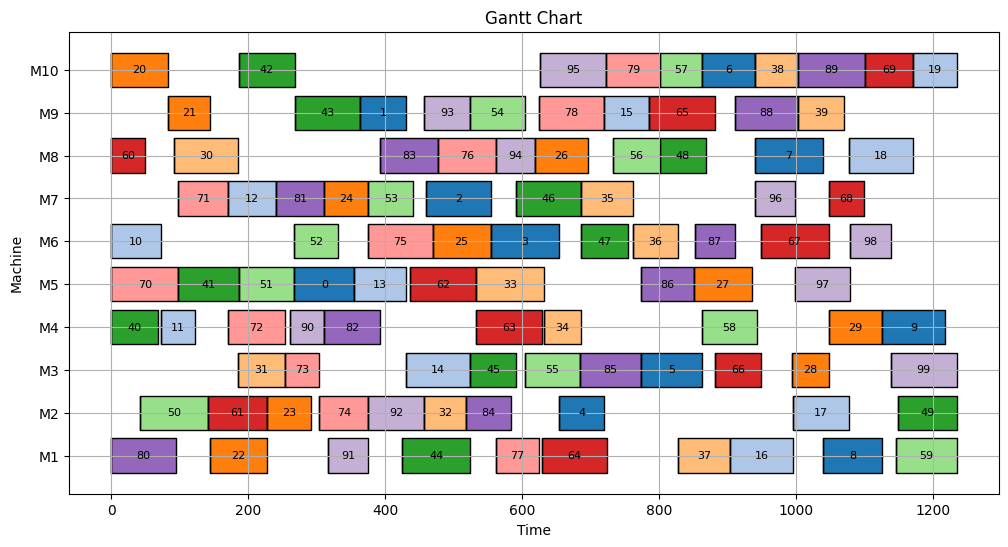

In [12]:
parameters = load_parameters("configs/milp.toml")
jobShopEnv = load_job_shop_env(parameters['instance'].get('problem_instance'))

results, jobShopEnv = run_MILP(jobShopEnv, **parameters)
plot_gantt_chart(jobShopEnv);

#### FJSP_DRL

INFO:root:Trained policy loaded from /saved_models/train_20240314_192906/song_10_5.pt.
INFO:root:Makespan: 38


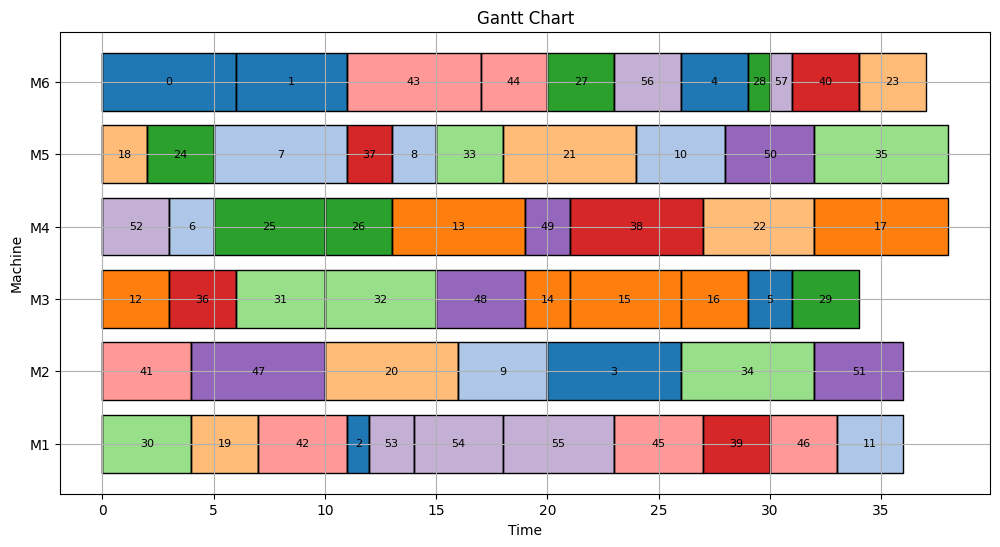

In [13]:
parameters = load_parameters("configs/fjsp_drl.toml")
jobShopEnv = load_job_shop_env(parameters['test_parameters'].get('problem_instance'))

makespan, jobShopEnv = run_FJSP_DRL(jobShopEnv, **parameters)
plot_gantt_chart(jobShopEnv);